In [1]:
import pandas as pd
import numpy as np
import glob
import pylab as plt
files=glob.glob('../*HA*')

import Bio
from Bio.PDB import PDBList
'''Selecting structures from PDB'''
pdbl = PDBList()
PDBlist2=['3AL4']
for i in PDBlist2:
    pdbl.retrieve_pdb_file(i,pdir='PDB',file_format='pdb')

Structure exists: 'PDB/pdb3al4.ent' 


In [2]:
!ls PDB/*

PDB/pdb3al4.ent


In [3]:
def getRBD(filename):
    
    with open(filename) as single:
        singlef=single.readlines()
    single.close()

    lines=np.array(singlef)
    lines=[lines[1],lines[4],lines[7]]
    
    R0=np.arange(104,320)
    R1=np.arange(320,550)
    R2=np.arange(0,104)

    L=np.zeros(550)
    RBD=0
    for i in R0:
        if (lines[0][i]!=lines[1][i]) & (lines[1][i]==lines[2][i]):
            RBD=RBD+1
            L[i]=L[i]+1
    RBDx=0
    for i in R1:
        if (lines[0][i]!=lines[1][i]) & (lines[1][i]==lines[2][i]):
            RBDx=RBDx+1
            L[i]=L[i]+1

    for i in R2:
        if (lines[0][i]!=lines[1][i]) & (lines[1][i]==lines[2][i]):
            RBDx=RBDx+1
            L[i]=L[i]+1

    if RBD+RBDx == 0:
        a=np.array([0,0])
    else:
        a=np.array([RBD,RBDx])/(RBD+RBDx)
    return a,L

In [4]:
A=[]
dL={}
i=0
for f in files:
    #print(f)
    if '2020-' not in f:
        a,L=getRBD(f)
        A=np.append(A,a)
        dL[i]=L
        i=i+1
A=A.reshape(int(len(A)/2),2)

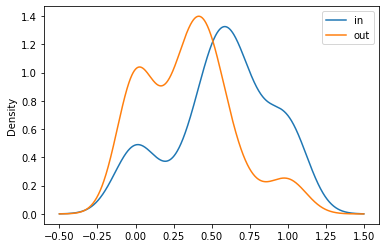

In [5]:
rbd=pd.DataFrame(A,columns=['in','out'])
rbd.plot.kde()

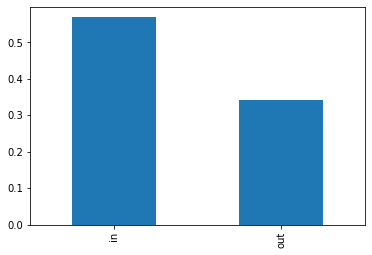

In [6]:
rbd.mean().plot(kind='bar')

In [7]:
pd.DataFrame(rbd.mean())

,0
in,0.568712
out,0.343053


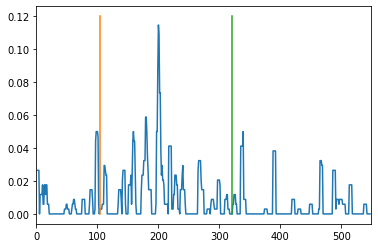

In [8]:
ax=pd.DataFrame(dL).transpose().mean().rolling(window=5, center=True).mean().plot()
plt.plot([104,104],[0,.12])
plt.plot([320,320],[0,.12])


In [9]:
def pymolwrite(ardict,pymolfile,
               PDBFILE='PDB/pdb3al4.ent'):
    '''
    ardict is in teh format: {key0:array,key1:array,...}
    where key is interpreted as an intensity
    
    
    '''
    FRAG0='run ./color_L1.py'
    FRAG4='set ray_opaque_background, 0'
    FRAG5='show surface'

    
    f = open(pymolfile, "w")
    f.write(FRAG0+'\n')
    
    
    COLOR_='0x006600'
    FRAG1='color_L1 '+PDBFILE+','
    FRAG2=', '+COLOR_+', 0,'+'1'+',0,grey80'
    
    
    K=list(ardict.keys())
    V=np.array(list(ardict.values()))
    nodes=list(V.astype(int).astype(str))
    nodes_=' '.join(nodes[:])
    #nodes_=str(ardict[K[0]])
    f.write(FRAG1+nodes_+FRAG2+'\n')
    
    #for k in K[1:]:
        #if len(list(ardict[k]))>1:
        #    nodes=list(ardict[k].astype(int).astype(str))
        #    nodes_=' '.join(nodes[:])
        #else:
        #nodes_=str(ardict[k])
        #COLOR_=#hex(int(COLOR_, 16) + 10).zfill(8)
        #FRAG3=', '+COLOR_+', 0,0,0,grey80'
        #f.write(FRAG1+nodes_+FRAG3+'\n')
    
    f.write(FRAG4+'\n')
    f.write(FRAG5+'\n')
    
    
    #pymolfile.write(FRAG1+head+FRAG3+'\n')
    return


In [12]:
DL=pd.DataFrame(pd.DataFrame(dL).mean(axis=1).rolling(window=5, center=True).mean(),columns=['pr']).dropna()
DL=DL[DL.pr>.02]
adict={}
DL=DL.sort_values('pr',ascending=False)
keys=DL.values
ind=DL.index.values
for k,v in zip(keys,ind):
    adict[k[0]]=v
adict.keys()

dict_keys([0.11470588235294114, 0.10882352941176468, 0.08823529411764704, 0.07352941176470584, 0.0588235294117647, 0.05, 0.049999999999999996, 0.04999999999999999, 0.04999999999999998, 0.04999999999999997, 0.04705882352941176, 0.044117647058823525, 0.04117647058823526, 0.03823529411764702, 0.03529411764705881, 0.03235294117647059, 0.032352941176470584, 0.03235294117647056, 0.02941176470588235, 0.02941176470588232, 0.026470588235294117, 0.026470588235294114, 0.0264705882352941, 0.026470588235294086, 0.023529411764705882, 0.023529411764705875, 0.023529411764705847, 0.02058823529411764, 0.020588235294117612])

In [21]:
ddf=pd.DataFrame(pd.DataFrame(dL).mean(axis=1).rolling(window=5, center=True).mean(),columns=['pr']).fillna(0)
ddf.index=ddf.index+1
ddf.to_csv('data.csv',sep='\t')

In [14]:
pymolwrite(adict,pymolfile='script.pml',PDBFILE='4edb.pdb')

In [15]:
! cat script.pml

run ./color_L1.py
color_L1 4edb.pdb,200 201 199 203 179 159 100 181 197 339 101 161 336 391 182 176 177 466 112 468 3 144 183 265 174 115 227 141 208, 0x006600, 0,1,0,grey80
set ray_opaque_background, 0
show surface


/home/ishanu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


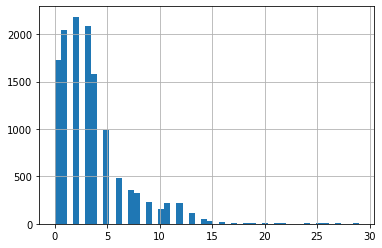

In [38]:
hf=pd.read_csv('../../../plotdata/ldist_histograms/h1n1humanHA_dom_ldists.csv')
ax=hf[(hf.ldist<30) & (hf.year!='2009_2010')].ldist.hist(bins=50)
hf[(hf.ldist<30) & (hf.year!='2009_2010')].ldist.to_csv('h1n1humanHA_dom_ldist.dat',index=None)

/home/ishanu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


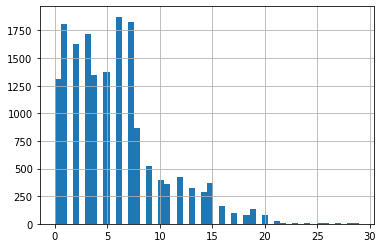

In [39]:
hf=pd.read_csv('../../../plotdata/ldist_histograms/h3n2humanHA_dom_ldists.csv')
ax=hf[(hf.ldist<30) & (hf.year!='2009_2010')].ldist.hist(bins=50)
hf[(hf.ldist<30) & (hf.year!='2009_2010')].ldist.to_csv('h3n2humanHA_dom_ldist.dat',index=None)

/home/ishanu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


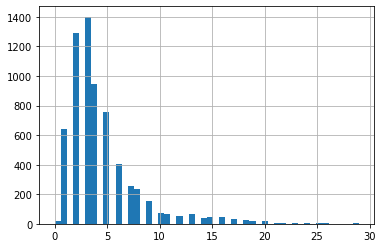

In [40]:
hf=pd.read_csv('../../../plotdata/ldist_histograms/h3n2humanNA_dom_ldists.csv')
ax=hf[(hf.ldist<30) & (hf.year!='2009_2010')].ldist.hist(bins=50)
hf[(hf.ldist<30) & (hf.year!='2009_2010')].ldist.to_csv('h3n2humanNA_dom_ldist.dat',index=None)

/home/ishanu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


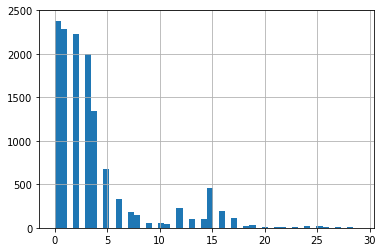

In [41]:
hf=pd.read_csv('../../../plotdata/ldist_histograms/h1n1humanNA_dom_ldists.csv')
ax=hf[(hf.ldist<30) & (hf.year!='2009_2010')].ldist.hist(bins=50)
hf[(hf.ldist<30) & (hf.year!='2009_2010')].ldist.to_csv('h1n1humanNA_dom_ldist.dat',index=None)